In [1]:
import matplotlib.pyplot as plt

from skimage import io, color
from skimage.transform import rescale
from skimage.draw import rectangle
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
import h5py

In [38]:
def load_transform(image_path):
    img = io.imread(image_path)
    img = img[25:195,0:160]
    img_gray = color.rgb2gray(img)
    
    thresh = threshold_otsu(img_gray)
    bw = closing(img_gray > thresh, square(3))
    cleared = bw
    label_image = label(cleared)
    for region in regionprops(label_image):
        if region.area >= 10:
            minr, minc, maxr, maxc = region.bbox
            rr, cc = rectangle(start=(minr, minc), end=(maxr, maxc), shape=cleared.shape)
            cleared[rr, cc] = 1

    image_rescaled = rescale(cleared, 1.0 / 3.0, anti_aliasing=False)
    
    return image_rescaled.reshape(3021)



In [45]:
loaded = load_transform('/media/andres/Data/spaceinvaders/atari_v1/screens/spaceinvaders/1/1.png')
print(loaded.shape)
plt.imshow(loaded)

0.0


/home/andres/thesis/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/andres/thesis/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [3]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
# encoding_dim = 256  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(3021,))
# "encoded" is the encoded representation of the input
encoded = Dense(1510, activation='relu')(input_img)
encoded = Dense(755, activation='relu')(encoded)
encoded = Dense(377, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(755, activation='relu')(encoded)
decoded = Dense(1510, activation='relu')(decoded)
decoded = Dense(3021, activation='sigmoid')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Using TensorFlow backend.


In [4]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3021)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1510)              4563220   
_________________________________________________________________
dense_2 (Dense)              (None, 755)               1140805   
_________________________________________________________________
dense_3 (Dense)              (None, 377)               285012    
Total params: 5,989,037
Trainable params: 5,989,037
Non-trainable params: 0
_________________________________________________________________


In [10]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
# encoding_dim = 256  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(3021,))
# "encoded" is the encoded representation of the input
encoded = Dense(1024, activation='relu')(input_img)
encoded = Dense(128, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(1024, activation='relu')(encoded)
decoded = Dense(3021, activation='sigmoid')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

type(x_train)

In [4]:
from os import listdir, path, walk
import numpy as np
import h5py

data_path = '/media/andres/Data/spaceinvaders/atari_v1/screens/spaceinvaders'

paths = listdir(data_path)
paths = [int(x) for x in paths]
paths.sort()
paths = [str(x) for x in paths][146:]
## 196
for x in paths:
    print("loaded path: {}".format(x))
    current_path = path.join(data_path, x)
    image_paths = listdir(current_path)
    image_paths = [int(x[:-4]) for x in image_paths]
    image_paths.sort()
    image_paths = [str(x) + '.png' for x in image_paths]
    data_paths = [path.join(current_path, image) for image in image_paths]
    i = 0
    data = np.zeros(shape=(len(data_paths), 57, 53))
    for image in data_paths:
        data[i] = load_transform(image)
        i = i + 1
    data = data.reshape((len(data), np.prod(data.shape[1:])))
    print(data.shape)
    transformed_path = '/media/andres/Baymax/transformed_data/space_invaders_{}.h5'.format(x)
    h5f = h5py.File(transformed_path)
    h5f.create_dataset('space_invaders', data=data)
    h5f.close()
    print("saved path: {}".format(transformed_path))


loaded path: 196


/home/andres/thesis/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/andres/thesis/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(3825, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_196.h5
loaded path: 198
(4657, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_198.h5
loaded path: 199
(4375, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_199.h5
loaded path: 200
(11115, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_200.h5
loaded path: 202
(3479, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_202.h5
loaded path: 203
(3802, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_203.h5
loaded path: 204
(839, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_204.h5
loaded path: 205
(4389, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_205.h5
loaded path: 206
(4336, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_206.h5
loaded path: 207
(762, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_207.h

loaded path: 294
(4398, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_294.h5
loaded path: 295
(7233, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_295.h5
loaded path: 296
(4767, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_296.h5
loaded path: 297
(3984, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_297.h5
loaded path: 298
(4035, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_298.h5
loaded path: 300
(3860, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_300.h5
loaded path: 301
(3626, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_301.h5
loaded path: 302
(622, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_302.h5
loaded path: 303
(2702, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_303.h5
loaded path: 304
(3315, 3021)
saved path: /media/andres/Baymax/transformed_data/spa

(4253, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_386.h5
loaded path: 387
(3991, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_387.h5
loaded path: 388
(3697, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_388.h5
loaded path: 389
(4246, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_389.h5
loaded path: 390
(4345, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_390.h5
loaded path: 391
(3275, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_391.h5
loaded path: 392
(7155, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_392.h5
loaded path: 393
(7523, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_393.h5
loaded path: 395
(7002, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_395.h5
loaded path: 396
(1625, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_396.

(4198, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_473.h5
loaded path: 474
(3105, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_474.h5
loaded path: 475
(9265, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_475.h5
loaded path: 476
(8635, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_476.h5
loaded path: 477
(7933, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_477.h5
loaded path: 478
(3846, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_478.h5
loaded path: 479
(4964, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_479.h5
loaded path: 482
(2301, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_482.h5
loaded path: 483
(491, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_483.h5
loaded path: 484
(772, 3021)
saved path: /media/andres/Baymax/transformed_data/space_invaders_484.h5

In [9]:
import numpy as np

num_to_load = 100000
split = int(num_to_load * 0.8)


x_train = data[0:split]
x_test = data[split:]

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(80000, 3021)
(20000, 3021)


In [10]:
autoencoder.fit(x_train, x_train,
                epochs=80,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 80000 samples, validate on 20000 samples
Epoch 1/80
80000/80000 [==============================] - 156s 2ms/step - loss: 0.2127 - val_loss: 0.1219
Epoch 2/80
80000/80000 [==============================] - 153s 2ms/step - loss: 0.1088 - val_loss: 0.0978
Epoch 3/80
80000/80000 [==============================] - 153s 2ms/step - loss: 0.0877 - val_loss: 0.0801
Epoch 4/80
80000/80000 [==============================] - 154s 2ms/step - loss: 0.0762 - val_loss: 0.0720
Epoch 5/80
80000/80000 [==============================] - 155s 2ms/step - loss: 0.0690 - val_loss: 0.0656
Epoch 6/80
80000/80000 [==============================] - 156s 2ms/step - loss: 0.0629 - val_loss: 0.0598
Epoch 7/80
80000/80000 [==============================] - 156s 2ms/step - loss: 0.0586 - val_loss: 0.0578
Epoch 8/80
80000/80000 [==============================] - 155s 2ms/step - loss: 0.0555 - val_loss: 0.0544
Epoch 9/80
80000/80000 [==============================] - 156s 2ms/step - loss: 0.0525 - val_loss: 0.0

In [11]:
encoded_images = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

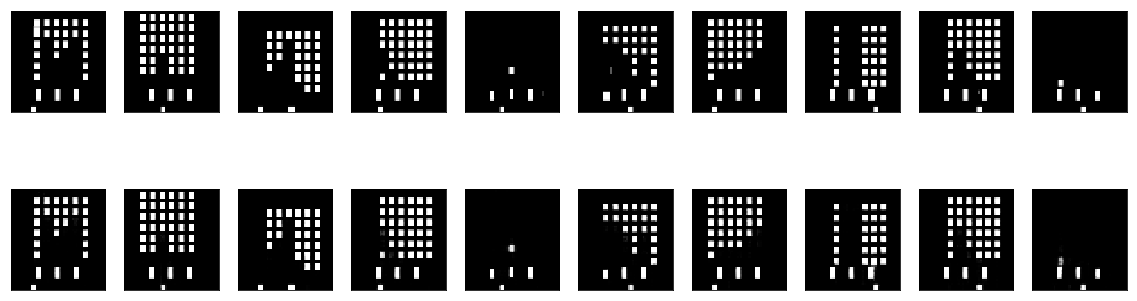

In [12]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(57, 53))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(57, 53))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
decoded_imgs[1]

In [ ]:
encoded_images[1]

In [ ]:
data_paths

In [13]:
autoencoder.save('/media/andres/Baymax/models/377.h5')

In [1]:
import h5py
import numpy as np

In [18]:
h5f = h5py.File('/home/andres/thesis/models/space_invaders.h5')
h5f.create_dataset('space_invaders', data=data)
h5f.close()

<HDF5 dataset "space_invaders": shape (100000, 57, 53), type "<f8">

In [7]:
h5f = h5py.File('/home/andres/thesis/models/space_invaders.h5', 'r')
data = h5f['space_invaders'][:]

In [8]:
data.shape

(100000, 57, 53)

In [2]:
file_5g = ['/media/andres/Baymax/transformed_data/space_invaders_1.h5',
'/media/andres/Baymax/transformed_data/space_invaders_2.h5',
'/media/andres/Baymax/transformed_data/space_invaders_3.h5',
'/media/andres/Baymax/transformed_data/space_invaders_4.h5',
'/media/andres/Baymax/transformed_data/space_invaders_5.h5',
'/media/andres/Baymax/transformed_data/space_invaders_6.h5',
'/media/andres/Baymax/transformed_data/space_invaders_7.h5',
'/media/andres/Baymax/transformed_data/space_invaders_8.h5',
'/media/andres/Baymax/transformed_data/space_invaders_9.h5',
'/media/andres/Baymax/transformed_data/space_invaders_10.h5',
'/media/andres/Baymax/transformed_data/space_invaders_12.h5',
'/media/andres/Baymax/transformed_data/space_invaders_13.h5',
'/media/andres/Baymax/transformed_data/space_invaders_14.h5',
'/media/andres/Baymax/transformed_data/space_invaders_15.h5',
'/media/andres/Baymax/transformed_data/space_invaders_16.h5',
'/media/andres/Baymax/transformed_data/space_invaders_17.h5',
'/media/andres/Baymax/transformed_data/space_invaders_20.h5',
'/media/andres/Baymax/transformed_data/space_invaders_21.h5',
'/media/andres/Baymax/transformed_data/space_invaders_22.h5',
'/media/andres/Baymax/transformed_data/space_invaders_23.h5',
'/media/andres/Baymax/transformed_data/space_invaders_27.h5',
'/media/andres/Baymax/transformed_data/space_invaders_32.h5',
'/media/andres/Baymax/transformed_data/space_invaders_33.h5',
'/media/andres/Baymax/transformed_data/space_invaders_34.h5',
'/media/andres/Baymax/transformed_data/space_invaders_35.h5',
'/media/andres/Baymax/transformed_data/space_invaders_36.h5',
'/media/andres/Baymax/transformed_data/space_invaders_37.h5',
'/media/andres/Baymax/transformed_data/space_invaders_38.h5',
'/media/andres/Baymax/transformed_data/space_invaders_39.h5',
'/media/andres/Baymax/transformed_data/space_invaders_40.h5',
'/media/andres/Baymax/transformed_data/space_invaders_41.h5',
'/media/andres/Baymax/transformed_data/space_invaders_42.h5',
'/media/andres/Baymax/transformed_data/space_invaders_43.h5',
'/media/andres/Baymax/transformed_data/space_invaders_44.h5',
'/media/andres/Baymax/transformed_data/space_invaders_45.h5',
'/media/andres/Baymax/transformed_data/space_invaders_46.h5',
'/media/andres/Baymax/transformed_data/space_invaders_48.h5',
'/media/andres/Baymax/transformed_data/space_invaders_49.h5',
'/media/andres/Baymax/transformed_data/space_invaders_50.h5',
'/media/andres/Baymax/transformed_data/space_invaders_51.h5',
'/media/andres/Baymax/transformed_data/space_invaders_52.h5',
'/media/andres/Baymax/transformed_data/space_invaders_53.h5',
'/media/andres/Baymax/transformed_data/space_invaders_54.h5',
'/media/andres/Baymax/transformed_data/space_invaders_55.h5',
'/media/andres/Baymax/transformed_data/space_invaders_56.h5',
'/media/andres/Baymax/transformed_data/space_invaders_57.h5',
'/media/andres/Baymax/transformed_data/space_invaders_58.h5',
'/media/andres/Baymax/transformed_data/space_invaders_59.h5',
'/media/andres/Baymax/transformed_data/space_invaders_60.h5',
'/media/andres/Baymax/transformed_data/space_invaders_61.h5',
'/media/andres/Baymax/transformed_data/space_invaders_62.h5',
'/media/andres/Baymax/transformed_data/space_invaders_65.h5',
'/media/andres/Baymax/transformed_data/space_invaders_66.h5',
'/media/andres/Baymax/transformed_data/space_invaders_67.h5']

In [ ]:
dataset = np.zeros(shape=(0,3021))
for data in file_5g:
    h5f = h5py.File(data, 'r')
    dataset =  np.vstack([dataset, h5f['space_invaders'][:]])
print(dataset.shape)

In [50]:
from skimage.io import imread
from skimage.transform import resize
from keras.utils import Sequence
import os
import numpy as np

class SpaceInvadersGenerator(Sequence):

    def __init__(self, space_invaders_screens_path, batch_size=1024, validation=False, train_percetage=0.8):
        self.paths = []
        self.batch_size = batch_size
        folder_paths = os.listdir(space_invaders_screens_path)
        folder_paths = [int(x) for x in folder_paths]
        folder_paths.sort()
        folder_paths = [str(x) for x in folder_paths]
        for x in folder_paths:
            current_path = os.path.join(space_invaders_screens_path, x)
            image_paths = os.listdir(current_path)
            image_paths = [int(x[:-4]) for x in image_paths]
            image_paths.sort()
            image_paths = [os.path.join(current_path, str(x) + '.png') for x in image_paths]
            self.paths += image_paths
        if validation:
            self.paths = self.paths[int(len(self.paths)*train_percetage):]
        else:
            self.paths = self.paths[:int(len(self.paths)*train_percetage)]

    def __len__(self):
        return int(np.floor(len(self.paths) / self.batch_size))

    def __getitem__(self, idx):
        indexes = self.paths[idx*self.batch_size:(idx+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y
    
    def __data_generation(self, paths):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, 3021))

        # Generate data
        for i, path in enumerate(paths):
            # Store sample
            X[i] = load_transform(path)

        return X, X
 

In [ ]:
sequence_train = SpaceInvadersGenerator('/media/andres/Data/spaceinvaders/atari_v1/screens/spaceinvaders', batch_size=32)
sequence_validation = SpaceInvadersGenerator('/media/andres/Data/spaceinvaders/atari_v1/screens/spaceinvaders', validation=True, batch_size=32)

In [52]:
len(sequence_train.paths) + len(sequence_validation.paths)

1766078

In [ ]:
autoencoder.fit_generator(generator=sequence_train, 
                          epochs=80,
                          validation_data=sequence_validation,
                          max_queue_size=10,
                          workers=4,
                          use_multiprocessing=True)


Epoch 1/80


/home/andres/thesis/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/andres/thesis/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/andres/thesis/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/andres/thesis/keras/lib/python3.6/site-packages/skimage/transf

  12/1379 [..............................] - ETA: 17:10:05 - loss: 0.6909